In [1]:
import wandb
import pandas as pd
import numpy as np

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [2]:
api = wandb.Api()


In [3]:

entity = "evangeorgerex"
project = "fwal"
# 9npryg91", "7i2o46ri
sweep_ids = [
    # # FWAL models
    # "ho0m3j5w", # FWAL
    # # "iw8hr7oj", # FWAl hierarchical
    # # "ryhck7mh", # FWAl hierarchical sigmoid 
    # # "bwhcxdf3", # FWAL hierarchical shared
    # # "54j0jkpy", # FWAL hierarchical shared sigmoid loss
    # # "9npryg91", # FWAL hierarchical TTI loss
    # "x9s9n05b", # FWAL hierarchical TTI loss L1 ablation
    '4p4opie9', # hyperparam tune mice_protein & madelon. F-Act no dropout
    "7i2o46ri", # hyperparam tune all datasets. F-Act no dropout
    'bga4xu49', # hyperparam tune all datasets. F-Act
]

In [4]:
run_id = '2y78aoec'

In [5]:
run = api.run(f"{entity}/{project}/{run_id}")

In [6]:
dataset_name = run.config.get("dataset", "Unknown")
                
model_name = run.config.get("model", "Unknown")

if model_name == "fwal":
    model_name = "F-Act"
    
# if run.config.get("hierarchical", False):
#     model_name = "F-Act hierarchical"
#     if run.config.get("share_mask", False):
#         model_name = "F-Act hierarchical shared"
#         if run.config.get("sigmoid_loss", False):
#             model_name = "F-Act hierarchical shared L_sig"
# if sweep_id == "x9s9n05b":
#     model_name = "F-Act hierarchical TTI (old)"
# if sweep_id in ["9npryg91", "7i2o46ri"]:
#     model_name = "F-Act hierarchical TTI"

run_data = {
"model": model_name,  # Assuming model name is stored in 'model_name'
"dataset": dataset_name,  # Assuming dataset name is stored in 'dataset_name'
"seed": run.config.get("seed_model_init", None),
"bestmodel_train/F1_weighted": run.summary.get("bestmodel_train/F1_weighted", float('nan')),
"bestmodel_valid/F1_weighted": run.summary.get("bestmodel_valid/F1_weighted", float('nan')),
"bestmodel_test/F1_weighted": run.summary.get("bestmodel_test/F1_weighted", float('nan')),
}

In [7]:
def get_tti_results(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    f1_weighted = []
    num_features = []

    history_dict = {}

    # Iterate through the run history to extract the desired metrics
    keys = [
        "tti_valid_metrics.F1_weighted", "tti_test_metrics.F1_weighted", "num_additional_features"
        ]
    for row in run.scan_history(keys=keys):
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            else:
                # print(key)
                continue
            
    max_index = np.argmax(history_dict['tti_valid_metrics.F1_weighted'])
    opt_tti_valid = history_dict['tti_valid_metrics.F1_weighted'][max_index]
    opt_tti_test = history_dict['tti_test_metrics.F1_weighted'][max_index]
    
    full_tti_valid = history_dict['tti_valid_metrics.F1_weighted'][-1]
    full_tti_test = history_dict['tti_test_metrics.F1_weighted'][-1]
    
    return opt_tti_valid, opt_tti_test, full_tti_valid, full_tti_test 
    

In [8]:
get_tti_results(run)

(0.6996906414719807,
 0.6822203604649191,
 0.6996906414719807,
 0.6822203604649191)

In [9]:
def get_history_dict(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    f1_weighted = []
    num_features = []

    history_dict = {}

    # Iterate through the run history to extract the desired metrics
    keys = [
        "tti_valid_metrics.F1_weighted", "tti_test_metrics.F1_weighted", "num_additional_features"
        ]
    for row in run.scan_history(keys=keys):
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            else:
                # print(key)
                continue
    return history_dict

In [10]:
history_dict = get_history_dict(run)

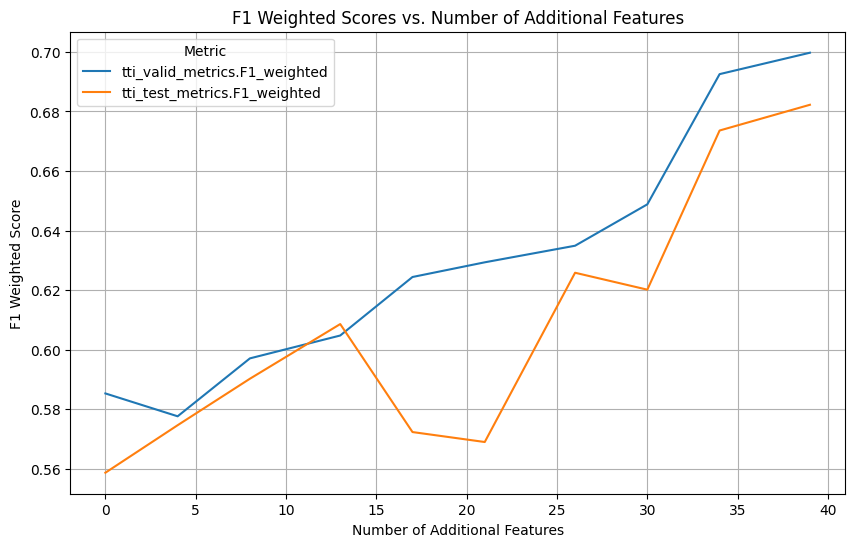

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Creating the data dictionary
data = history_dict

# Converting the dictionary to a DataFrame
df = pd.DataFrame(data)

# Melting the DataFrame to a long format
df_long = pd.melt(df, id_vars=['num_additional_features'], var_name='metric', value_name='score')

# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='num_additional_features', y='score', hue='metric')
plt.title('F1 Weighted Scores vs. Number of Additional Features')
plt.xlabel('Number of Additional Features')
plt.ylabel('F1 Weighted Score')
plt.legend(title='Metric')
plt.grid(True)
plt.show()
